In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [3]:
pip install tqdm

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
data_dir = "/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/DTD"

num_classes = 47
batch_size = 32
num_epochs = 10

model = models.mobilenet_v2(pretrained=True)
# /media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/DTD
model.classifier = nn.Linear(1280, num_classes)
model

/home/abdul/miniconda3/envs/detr/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdul/miniconda3/envs/detr/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
       # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [8]:
train_dataset_size = len(image_datasets['train'])
val_dataset_size = len(image_datasets['val'])

print("Number of training samples: ", train_dataset_size)
print("Number of validation samples: ", val_dataset_size)


Number of training samples:  2961
Number of validation samples:  329


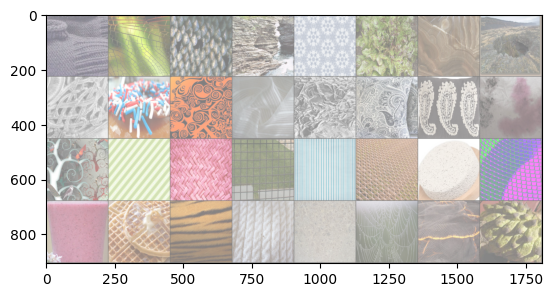

NameError: name 'classes' is not defined

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders_dict['train'])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(2)))

In [10]:
model_ft = model.to(device)

params_to_update = []

for name, param in model_ft.named_parameters():
    param.requires_grad == False
    

for name,param in model_ft.named_parameters():

    if 'features.17' in name:
        param.requires_grad == True
        params_to_update.append(param)        

    if 'features.18' in name:
        param.requires_grad == True
        params_to_update.append(param)
        
    if 'classifier' in name:
        param.requires_grad == True
        params_to_update.append(param)
        

In [11]:
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=25)

----------
train Loss: 3.5644 Acc: 0.1557
val Loss: 2.9831 Acc: 0.4012

----------
train Loss: 2.7149 Acc: 0.4218
val Loss: 2.2341 Acc: 0.5502

----------
train Loss: 2.1493 Acc: 0.5535
val Loss: 1.7832 Acc: 0.6596

----------
train Loss: 1.8148 Acc: 0.5937
val Loss: 1.5375 Acc: 0.6596

----------
train Loss: 1.5959 Acc: 0.6228
val Loss: 1.4035 Acc: 0.6687

----------
train Loss: 1.4600 Acc: 0.6390
val Loss: 1.2950 Acc: 0.6809

----------
train Loss: 1.3387 Acc: 0.6579
val Loss: 1.2167 Acc: 0.6809

----------
train Loss: 1.2630 Acc: 0.6778
val Loss: 1.1675 Acc: 0.6869

----------
train Loss: 1.1957 Acc: 0.6903
val Loss: 1.1357 Acc: 0.6869

----------
train Loss: 1.1331 Acc: 0.7042
val Loss: 1.1021 Acc: 0.7173

----------
train Loss: 1.0735 Acc: 0.7163
val Loss: 1.0722 Acc: 0.7112

----------
train Loss: 1.0169 Acc: 0.7312
val Loss: 1.0487 Acc: 0.7021

----------
train Loss: 0.9753 Acc: 0.7403
val Loss: 1.0274 Acc: 0.7112

----------
train Loss: 0.9397 Acc: 0.7386
val Loss: 1.0177 Acc: 

In [15]:
img_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = torchvision.datasets.ImageFolder(data_dir + '/val',transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False, num_workers=4)

In [12]:
class_names = image_datasets['train'].classes
print(class_names)

['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 'zigzagged']


In [16]:
# test-the-model
classes = ['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 
           'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 
           'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike',
           'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 
           'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 
           'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 
           'zigzagged']

model_ft.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
       
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        i=0
        for label in labels:
            print("input",classes[label],"output",classes[predicted[i]])
           
            i=i+1

        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
    print('correct: {:d}  total: {:d}'.format(correct, total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')

input banded output lined
input banded output banded
input banded output banded
input banded output grooved
input banded output banded
input banded output banded
input banded output banded
input blotchy output blotchy
input blotchy output blotchy
input blotchy output blotchy
input blotchy output blotchy
input blotchy output marbled
input blotchy output stained
input blotchy output stained
input braided output pleated
input braided output braided
input braided output spiralled
input braided output braided
input braided output braided
input braided output braided
input braided output knitted
input bubbly output bubbly
input bubbly output bubbly
input bubbly output matted
input bubbly output bubbly
input bubbly output bubbly
input bubbly output bubbly
input bubbly output sprinkled
input bumpy output perforated
input bumpy output scaly
input bumpy output matted
input bumpy output bumpy
input bumpy output bumpy
input bumpy output bubbly
input bumpy output pitted
input chequered output chequ

In [20]:


from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

classes = ['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 
           'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 
           'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike',
           'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 
           'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 
           'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 
           'zigzagged']

loader = transforms.Compose([transforms.Resize((224,224)),
                             transforms.ToTensor(), 
                              #normalize
                            ])

def image_loader(image_name):

    image = Image.open(image_name)
    image = image.convert('RGB')
    image = loader(image)
    image = image.unsqueeze(0)  
    image = image.cuda()
    return image  #assumes that you're using GPU

model = model_ft
model.eval()
image = image_loader('/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/DTD/val/smeared/smeared_0144.jpg')
pred = (model(image)).data.cpu().numpy().argmax()

print('Prediction: ', pred)
print('Class: ', classes[pred])



Prediction:  34
Class:  smeared


In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [ 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in [ 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [23]:
# helper function to un-normalize and display an image
def imshow(img):
    img = Image.open(img)
    plt.imshow(img)  

In [24]:
import glob

images = []
for f in glob.iglob("/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/DTD/val/smeared/smeared_0144.jpg'"):
    images.append(f)
    
#images